**DO NOT CHANGE ANYONE'S CODE WITHOUT CONSENT** <br>
Upload archive.zip <br>
run the whole code under the heading preprocessing pipeline <br>
DO NOT run OPTIONAL PART code <br>
in clustering task, you have to use two files <br>
merged_enery_data - merged_df variable <br>
weather_merged - weather_clean variable

# **Preprocessing Pipeline**

Extracting Data

In [ ]:
!unzip "/content/archive.zip" -d "/content/data"

Archive:  /content/archive.zip
replace /content/data/EIA930_BALANCE_2018_Jul_Dec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
data_dir= "/content/data/"

Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import json
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from flask import Flask, render_template
import warnings
warnings.filterwarnings('ignore')

Inspection of Data - CSV

In [ ]:
def inspect_csv(filepath):
    print(f"Inspecting {os.path.basename(filepath)}")
    csv_df = pd.read_csv(filepath, parse_dates=True, low_memory=False)
    print(f"Shape: {csv_df.shape}")
    print("Columns:", csv_df.columns.tolist())
    print("Data Types:\n", csv_df.dtypes)
    for col in csv_df.columns:
            print(f"{col}: {csv_df[col].nunique()} unique values")
    print("\n\n")
    return csv_df


In [ ]:
data_dir = '/content/data/'

if os.path.exists(data_dir):
    csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    print(f"Found files: {csv_files}")
else:
    print(f"Directory {data_dir} does not exist.")


Found files: ['EIA930_SUBREGION_2019_Jan_Jun.csv', 'EIA930_BALANCE_2018_Jul_Dec.csv', 'texas2018.csv', 'texas2020.csv', 'EIA930_BALANCE_2019_Jul_Dec.csv', 'EIA930_BALANCE_2019_Jan_Jun.csv', 'EIA930_SUBREGION_2018_Jul_Dec.csv', 'texas2019.csv', 'EIA930_SUBREGION_2020_Jan_Jun.csv', 'EIA930_BALANCE_2020_Jan_Jun.csv', 'cleaned_subregion_data.csv', 'cleaned_texas_data.csv', 'EIA930_SUBREGION_2019_Jul_Dec.csv', 'cleaned_balance_data.csv']


In [ ]:
csv_files= [f for f in os.listdir(data_dir) if f.endswith('.csv')]
dfs_dict= {}

for file in csv_files:
    path = os.path.join(data_dir, file)
    csv_df = inspect_csv(path)
    dfs_dict[file] = csv_df


Inspecting EIA930_SUBREGION_2019_Jan_Jun.csv
Shape: (356140, 7)
Columns: ['Balancing Authority', 'Data Date', 'Hour Number', 'Sub-Region', 'Demand (MW)', 'Local Time at End of Hour', 'UTC Time at End of Hour']
Data Types:
 Balancing Authority          object
Data Date                    object
Hour Number                   int64
Sub-Region                   object
Demand (MW)                  object
Local Time at End of Hour    object
UTC Time at End of Hour      object
dtype: object
Balancing Authority: 8 unique values
Data Date: 181 unique values
Hour Number: 24 unique values
Sub-Region: 82 unique values
Demand (MW): 20351 unique values
Local Time at End of Hour: 4344 unique values
UTC Time at End of Hour: 4346 unique values



Inspecting EIA930_BALANCE_2018_Jul_Dec.csv
Shape: (290046, 23)
Columns: ['Balancing Authority', 'Data Date', 'Hour Number', 'Local Time at End of Hour', 'UTC Time at End of Hour', 'Demand Forecast (MW)', 'Demand (MW)', 'Net Generation (MW)', 'Total Interchange

Inspection of Data - JSON

In [ ]:
def inspect_json(filepath):
    print(f"Inspecting {os.path.basename(filepath)}")
    with open(filepath, 'r') as f:
        data_json = json.load(f)
    if isinstance(data_json, dict):
        keys = list(data_json.keys())
        print("Top-level keys:", keys)
        if 'features' in data_json:
            print("Sample feature keys:", list(data_json['features'][0].keys()))
    elif isinstance(data_json, list):
        print("First item keys:", list(data_json[0].keys()))
    print("\n")

json_files = [f for f in os.listdir(data_dir) if f.endswith('.json')]
for file in json_files:
    inspect_json(os.path.join(data_dir, file))


Inspecting dallas.json
First item keys: ['time', 'summary', 'icon', 'precipIntensity', 'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility']


Inspecting san_jose.json
First item keys: ['time', 'summary', 'icon', 'precipIntensity', 'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility']


Inspecting seattle.json
First item keys: ['time', 'summary', 'icon', 'precipIntensity', 'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility']


Inspecting san_diego.json
First item keys: ['time', 'summary', 'icon', 'precipIntensity', 'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed', 'windGust'

Merging Energy Data

Merging all subregion files to get merged_subregion

Merging all balance files to get merged_balance

In [ ]:
# load and concatenate all EIA930 subregion files
subregion_files = glob.glob(data_dir + 'EIA930_SUBREGION_*.csv')
subregion_list = []
for file in subregion_files:
    df = pd.read_csv(file, parse_dates=['Local Time at End of Hour', 'UTC Time at End of Hour'])
    subregion_list.append(df)
eia_subregion_all = pd.concat(subregion_list, ignore_index=True)

# load and concatenate all EIA930 balance files
balance_files = glob.glob(data_dir + 'EIA930_BALANCE_*.csv')
balance_list = []
for file in balance_files:
    df = pd.read_csv(file, parse_dates=['Local Time at End of Hour', 'UTC Time at End of Hour'])
    balance_list.append(df)
eia_balance_all = pd.concat(balance_list, ignore_index=True)

# save merged outputs
eia_subregion_all.to_csv('merged_subregion.csv', index= False)
eia_balance_all.to_csv('merged_balance.csv', index= False)

print("Merged raw subregion and balance datasets saved as 'merged_subregion.csv' and 'merged_balance.csv'")


Merged raw subregion and balance datasets saved as 'merged_subregion.csv' and 'merged_balance.csv'


Missing Values

In [ ]:
# function to print missing % per column
def missing_percentage(df, name):
    print(f"\nMissing % in {name}:")
    print((df.isna().mean() * 100).round(2).sort_values(ascending=False))

# check both files
missing_percentage(eia_subregion_all, "Subregion Data")
missing_percentage(eia_balance_all, "Balance Data")


Missing % in Subregion Data:
Demand (MW)                  9.62
Data Date                    0.00
Balancing Authority          0.00
Hour Number                  0.00
Sub-Region                   0.00
Local Time at End of Hour    0.00
UTC Time at End of Hour      0.00
dtype: float64

Missing % in Balance Data:
Net Generation (MW) from Unknown Fuel Sources             100.00
Net Generation (MW) (Imputed)                              99.29
Demand (MW) (Imputed)                                      98.76
Net Generation (MW) from Nuclear                           73.02
Net Generation (MW) from All Petroleum Products            66.77
Net Generation (MW) from Wind                              56.31
Net Generation (MW) from Other Fuel Sources                47.13
Net Generation (MW) from Coal                              44.35
Net Generation (MW) from Solar                             39.28
Net Generation (MW) from Hydropower and Pumped Storage     30.19
Net Generation (MW) from Natural Gas   

Dropping columns with missing values above threshold.

In [ ]:
# function to drop columns with >X% missing
def drop_columns_missing_threshold(df, threshold_percent):
    missing_fraction = df.isna().mean()
    cols_to_keep = missing_fraction[missing_fraction <= threshold_percent / 100].index
    return df[cols_to_keep]

subregion_clean = drop_columns_missing_threshold(eia_subregion_all, 5)
balance_clean = drop_columns_missing_threshold(eia_balance_all, 20)

print(f"Subregion cleaned shape: {subregion_clean.shape}")
print(f"Balance cleaned shape: {balance_clean.shape}")

# remaining columns
print("\nSubregion columns:", list(subregion_clean.columns))
print("\nBalance columns:", list(balance_clean.columns))



Subregion cleaned shape: (1355952, 6)
Balance cleaned shape: (1037498, 12)

Subregion columns: ['Balancing Authority', 'Data Date', 'Hour Number', 'Sub-Region', 'Local Time at End of Hour', 'UTC Time at End of Hour']

Balance columns: ['Balancing Authority', 'Data Date', 'Hour Number', 'Local Time at End of Hour', 'UTC Time at End of Hour', 'Demand Forecast (MW)', 'Demand (MW)', 'Net Generation (MW)', 'Total Interchange (MW)', 'Sum(Valid DIBAs) (MW)', 'Demand (MW) (Adjusted)', 'Net Generation (MW) (Adjusted)']


Merge the clean balance and subregion data

In [ ]:
merged_df = pd.merge(
    subregion_clean,
    balance_clean,
    on=['Balancing Authority', 'Data Date', 'Hour Number'],
    how='inner',
    suffixes=('_subregion', '_balance')
)

print(f"Merged shape: {merged_df.shape}")
merged_df.head()



merged_df.to_csv('merged_energy_data.csv', index=False)

Merged shape: (1308720, 15)


Cleaning Merged Energy Data

Numeric columns are being treated as categorical because of ' , '

In [ ]:
numeric_cols_energy= [
    'Demand Forecast (MW)',
    'Demand (MW)',
    'Net Generation (MW)',
    'Total Interchange (MW)',
    'Sum(Valid DIBAs) (MW)',
    'Demand (MW) (Adjusted)',
    'Net Generation (MW) (Adjusted)'
]

for col in numeric_cols_energy:
    merged_df[col]= merged_df[col].str.replace(',', '', regex=False)  # remove commas
    merged_df[col]= pd.to_numeric(merged_df[col], errors='coerce')


In [ ]:
merged_df.dropna(subset=['Demand Forecast (MW)', 'Demand (MW) (Adjusted)'], inplace=True)
for col in numeric_cols_energy:
    merged_df[col]= merged_df.groupby(['Sub-Region', 'Hour Number'])[col].transform(
        lambda x: x.fillna(x.mean())
    )

Merging Weather data

In [ ]:
# city json files
city_files = [
    'san_diego.json', 'la.json', 'philadelphia.json', 'san_antonio.json',
    'dallas.json', 'phoenix.json', 'nyc.json', 'san_jose.json',
    'seattle.json', 'houston.json'
]

merged_weather = []

for file in city_files:
    # load JSON
    df = pd.read_json(data_dir + file)

    # extract city name from filename (remove .json)
    city_name = file.replace('.json', '')

    # add city column
    df['city'] = city_name

    # convert 'time' to datetime
    df['local_time'] = pd.to_datetime(df['time'], unit='s')

    # append to list
    merged_weather.append(df)

# concatenate all cities into one dataframe
weather_all = pd.concat(merged_weather, ignore_index=True)

Missing Values

In [ ]:
weather_clean= drop_columns_missing_threshold(weather_all, 10)

# remaining columns
print("Weather columns:", list(weather_clean.columns))

weather_clean.to_csv('weather_merged.csv', index= False)

print("Merged weather datasets saved as 'weather_merged.csv'")

Weather columns: ['time', 'summary', 'icon', 'precipIntensity', 'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility', 'city', 'local_time']
Merged weather datasets saved as 'weather_merged.csv'


Cleaning Weather Data

In [ ]:
numeric_cols_waether= ['precipIntensity', 'precipProbability', 'temperature', 'apparentTemperature', 'humidity', 'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility']
weather_clean.dropna(subset=['summary', 'icon'], inplace=True)
for col in numeric_cols_waether:
    if weather_clean[col].dtype in ['float64', 'int64'] and weather_clean[col].isnull().any():
        weather_clean[col].fillna(weather_clean[col].mean(), inplace=True)




Feature Engineering

In [ ]:
merged_df['hour'] = merged_df['Local Time at End of Hour_balance'].dt.hour
merged_df['day_of_week'] = merged_df['Local Time at End of Hour_balance'].dt.dayofweek
merged_df['month'] = merged_df['Local Time at End of Hour_balance'].dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

merged_df['season']= merged_df['month'].apply(get_season)


In [ ]:
weather_clean['hour'] = weather_clean['local_time'].dt.hour
weather_clean['day_of_week'] = weather_clean['local_time'].dt.dayofweek
weather_clean['month'] = weather_clean['local_time'].dt.month
weather_clean['season'] = weather_clean['month'].apply(get_season)

Aggregation

In [ ]:
# daily/weekly aggregation on energy data
daily_energy= merged_df.groupby(merged_df['Local Time at End of Hour_balance'].dt.date).agg({
    'Demand (MW)': ['mean', 'max', 'min'],
    'Net Generation (MW)': ['mean', 'sum'],
    'Total Interchange (MW)': ['mean'],
}).reset_index().rename(columns={'Local Time at End of Hour_balance': 'date'})

weekly_energy= merged_df.groupby(pd.Grouper(key= 'Local Time at End of Hour_balance', freq= 'W')).agg({
    'Demand (MW)': 'mean',
    'Net Generation (MW)': 'sum'
}).reset_index()

In [ ]:
# daily/weekly aggregation on weather data
daily_weather= weather_clean.groupby(weather_clean['local_time'].dt.date).agg({
    'temperature': ['mean', 'max', 'min'],
    'humidity': 'mean',
    'windSpeed': 'mean'
}).reset_index().rename(columns={'local_time': 'date'})

weekly_weather= weather_clean.groupby(pd.Grouper(key='local_time', freq='W')).agg({
    'temperature': 'mean',
    'humidity': 'mean'
}).reset_index()

Outlier Analysis

In [ ]:
def outliers_analysis(df, features, contamination_rate, time_col, title= ''):
  outlier_model= IsolationForest(n_estimators= 100, contamination= contamination_rate, random_state= 42)
  df['Anomaly']= outlier_model.fit_predict(df[features])
  # -1(outlier), 1(normal)
  df['Anomaly']= df['Anomaly'].map({1: 0, -1: 1})

  # anomaly count
  print(f"{title} - Anomalies Detected: {df['Anomaly'].sum()} out of {len(df)} records")

In [ ]:
outliers_analysis(
    df=merged_df.copy(),
    features=numeric_cols_energy,
    contamination_rate=0.02,
    time_col='Local Time at End of Hour_balance',
    title='Energy Data'
)


Energy Data - Anomalies Detected: 25988 out of 1300024 records


In [ ]:
outliers_analysis(
    df=weather_clean.copy(),
    features=numeric_cols_waether,
    contamination_rate=0.03,
    time_col='local_time',
    title='Weather Data'
)


Weather Data - Anomalies Detected: 4964 out of 165458 records


In [ ]:
import plotly.express as px

fig = px.histogram(weather_clean,
                   x='temperature',
                   color='city',
                   title='Temperature Distribution by City',
                   labels={'temperature': 'Temperature (°C)'},
                   histnorm='density',
                   marginal='rug',
                   opacity=0.7,
                   facet_col='city',
                   facet_col_wrap=5)

fig.update_layout(bargap=0.2,
                  showlegend=False)
fig.show()




---



# OPTIONAL PART


merging texas data

In [ ]:
import pandas as pd

# Load Texas datasets
texas2018 = pd.read_csv(data_dir + 'texas2018.csv')
texas2019 = pd.read_csv(data_dir + 'texas2019.csv')
texas2020 = pd.read_csv(data_dir + 'texas2020.csv')

# Stack them
texas_all = pd.concat([texas2018, texas2019, texas2020], ignore_index=True)

# Fix '24:00' and ' DST' in timestamps
def fix_hourending(time_str):
    # Remove any trailing ' DST' or ' CST' etc.
    time_str = time_str.strip().split(' ')[0] + ' ' + time_str.strip().split(' ')[1]

    if '24:00' in time_str:
        date_part = time_str.split(' ')[0]
        fixed_time = pd.to_datetime(date_part, format='%m/%d/%Y') + pd.Timedelta(days=1)
        return fixed_time
    else:
        return pd.to_datetime(time_str, format='%m/%d/%Y %H:%M')

# Apply the fix
texas_all['local_time'] = texas_all['HourEnding'].apply(fix_hourending)

# Reshape wide to long format
texas_long = texas_all.melt(
    id_vars=['local_time'],
    value_vars=['COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH', 'SCENT', 'WEST', 'ERCOT'],
    var_name='city',
    value_name='load_mw'
)

# Optional: save reshaped Texas dataset
texas_long.to_csv('texas_merged_long.csv', index=False)

print("✅ Merged and reshaped Texas datasets saved as 'texas_merged_long.csv'")


In [ ]:
texas_all.head()

# Clustering Algorithms 2

In [ ]:
merged_df.columns

Index(['Balancing Authority', 'Data Date', 'Hour Number', 'Sub-Region',
       'Local Time at End of Hour_subregion',
       'UTC Time at End of Hour_subregion',
       'Local Time at End of Hour_balance', 'UTC Time at End of Hour_balance',
       'Demand Forecast (MW)', 'Demand (MW)', 'Net Generation (MW)',
       'Total Interchange (MW)', 'Sum(Valid DIBAs) (MW)',
       'Demand (MW) (Adjusted)', 'Net Generation (MW) (Adjusted)', 'hour',
       'day_of_week', 'month', 'season'],
      dtype='object')

In [ ]:
weather_clean.columns

Index(['time', 'summary', 'icon', 'precipIntensity', 'precipProbability',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover',
       'uvIndex', 'visibility', 'city', 'local_time', 'hour', 'day_of_week',
       'month', 'season', 'date', 'date_only'],
      dtype='object')

PCA

We will add a city column in subregion_df by mapping; city -> (Balancing Authority, Sub-Region)

In [ ]:
# Mapping from city -> (Balancing Authority, Sub-Region)
city_mapping = {
    'nyc': ('NYIS', 'ZONJ'),
    'la': ('CISO', 'SCE'),
    'houston': ('ERCO', 'COAS'),
    'philadelphia': ('PJM', 'PE'),
    'san antonio': ('ERCO', 'SCEN'),
    'san diego': ('CISO', 'SDGE'),
    'dallas': ('ERCO', 'NCEN'),
    'san jose': ('CISO', 'PGAE')
}

# Reverse mapping
rev_mapping = {v: k for k, v in city_mapping.items()}

# Create a copy of merged_df
subregion_df = merged_df.copy()

# Add city column based on reverse mapping
subregion_df['city'] = subregion_df.apply(
    lambda row: rev_mapping.get((row['Balancing Authority'], row['Sub-Region'])), axis=1
)

#drop rows where city could not be determined
subregion_df = subregion_df.dropna(subset=['city'])



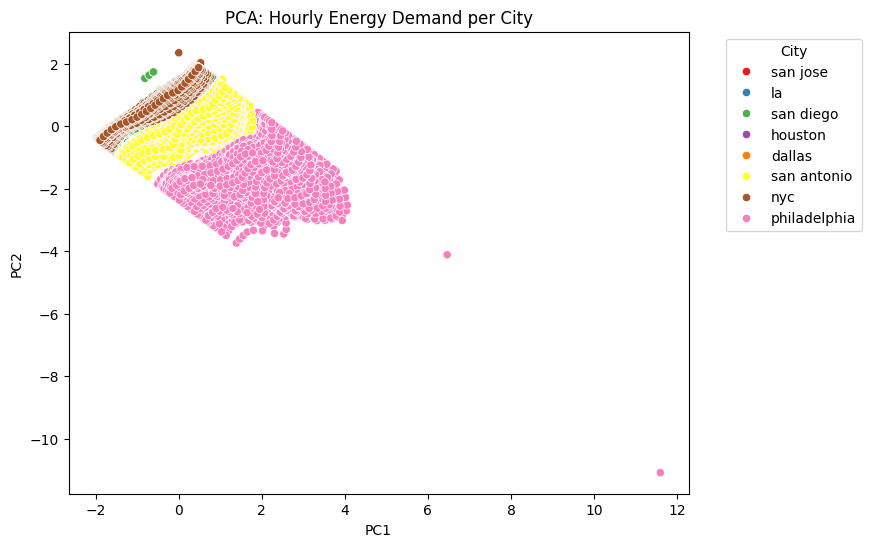

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

hourly_data = subregion_df[['city', 'Hour Number', 'Demand (MW)']]
hourly_data = hourly_data[hourly_data['city'].isin(city_mapping.keys())]
hourly_data = hourly_data.dropna()

# Standardize the features
X = hourly_data[['Hour Number', 'Demand (MW)']]  # Only the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize the PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hourly_data['city'], palette='Set1')
plt.title('PCA: Hourly Energy Demand per City')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


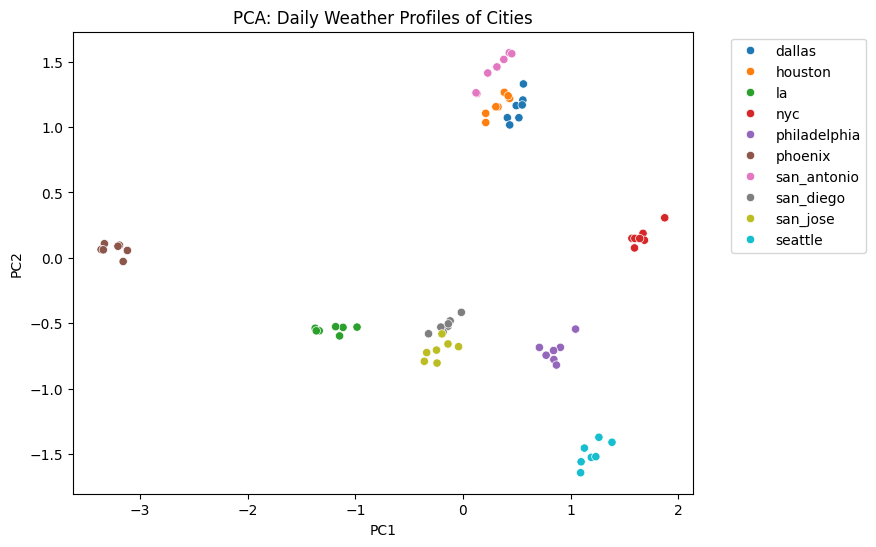

In [ ]:
weather_daily = weather_clean.groupby(['city', 'day_of_week'])[['temperature', 'humidity', 'windSpeed']].mean().reset_index()
features = ['temperature', 'humidity', 'windSpeed']

# Standardize
X_weather = StandardScaler().fit_transform(weather_daily[features])

# PCA
pca = PCA(n_components=2)
X_pca_weather = pca.fit_transform(X_weather)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_weather[:, 0], y=X_pca_weather[:, 1], hue=weather_daily['city'])
plt.title('PCA: Daily Weather Profiles of Cities')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


K-Means

In [ ]:

# # Mapping from city -> (Balancing Authority, Sub-Region)
# city_mapping = {
#     'nyc': ('NYIS', 'ZONJ'),
#     'la': ('CISO', 'SCE'),
#     'houston': ('ERCO', 'COAS'),
#     'philadelphia': ('PJM', 'PE'),
#     'san antonio': ('ERCO', 'SCEN'),
#     'san diego': ('CISO', 'SDGE'),
#     'dallas': ('ERCO', 'NCEN'),
#     'san jose': ('CISO', 'PGAE')
# }

# # Reverse mapping: (Balancing Authority, Sub-Region) -> city
# reverse_map = {v: k for k, v in city_mapping.items()}

# # Clean up and rename
# columns_to_keep = [
#     'Balancing Authority', 'Sub-Region', 'Data Date', 'Demand (MW)'
# ]
# subregion_df = merged_df[columns_to_keep].copy()

# Rename for consistency
subregion_df.rename(columns={
    'Balancing Authority': 'balancing_authority',
    'Sub-Region': 'subregion',
    'Data Date': 'date',
    'Demand (MW)': 'demand'
}, inplace=True)

# Convert date to datetime
subregion_df['date'] = pd.to_datetime(subregion_df['date'], format='%m/%d/%Y')

# Standardize city names (lowercase, no whitespace — already handled by mapping)
subregion_df['city'] = subregion_df['city'].str.lower().str.strip()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# --- Process weather data ---

reduced_cols_weather = ['temperature', 'humidity', 'pressure', 'windSpeed', 'uvIndex', 'local_time', 'city']
weather_df = weather_clean[reduced_cols_weather]

# Ensure datetime format and standardize city
weather_df['local_time'] = pd.to_datetime(weather_df['local_time'])
weather_df['date'] = weather_df['local_time'].dt.date
weather_df['city'] = weather_df['city'].str.lower().str.strip()

# Group by city and date
weather_grouped = weather_df.groupby(['city', 'date'])['temperature'].mean().reset_index(name='avg_temperature')

# --- Process subregion (demand) data ---
demand_df = subregion_df.copy()

# Group by city and date
demand_grouped = demand_df.groupby(['city', 'date'])['demand'].mean().reset_index(name='avg_demand')


# Ensure 'date' columns match in type
weather_grouped['date'] = pd.to_datetime(weather_grouped['date'])
demand_grouped['date'] = pd.to_datetime(demand_grouped['date'])

# Merge on city and date
combined_df = pd.merge(weather_grouped, demand_grouped, on=['city', 'date'], how='inner')
combined_df.dropna(inplace=True)


# Create city-day label
combined_df['city_day'] = combined_df['city'] + '-' + combined_df['date'].astype(str)

# KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
combined_df['cluster'] = kmeans.fit_predict(combined_df[['avg_temperature', 'avg_demand']])

# --- Plot ---
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=combined_df,
    x='avg_temperature',
    y='avg_demand',
    hue='cluster',
    palette='Set2',
    s=80
)

# Optional: Label each point
# for _, row in combined_df.iterrows():
#     plt.text(row['avg_temperature'], row['avg_demand'], row['city_day'], fontsize=7, alpha=0.6)

plt.title('Clusters of Cities by Avg Temperature and Energy Demand')
plt.xlabel('Average Temperature (°F)')
plt.ylabel('Average Energy Demand (MW)')
plt.grid(True)
plt.tight_layout()
#plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

def generate_kmeans_plot(weather_df, subregion_df, k=2):
    # --- Select and clean weather data ---
    reduced_cols_weather = ['temperature', 'humidity', 'pressure', 'windSpeed', 'uvIndex', 'local_time', 'city']
    weather_df = weather_df[reduced_cols_weather].copy()

    # Check if 'city' and 'local_time' exist in weather_df
    if 'city' not in weather_df.columns:
        raise KeyError("The 'city' column is missing in the weather DataFrame")
    if 'local_time' not in weather_df.columns:
        raise KeyError("The 'local_time' column is missing in the weather DataFrame")

    weather_df['local_time'] = pd.to_datetime(weather_df['local_time'])
    weather_df['date'] = weather_df['local_time'].dt.date
    weather_df['city'] = weather_df['city'].str.lower().str.strip()
    weather_grouped = weather_df.groupby(['city', 'date'])['temperature'].mean().reset_index(name='avg_temperature')

    # --- Clean demand data ---
    demand_df = subregion_df.copy()

    # Check if 'city' and 'local_time' exist in demand_df
    if 'city' not in demand_df.columns:
        raise KeyError("The 'city' column is missing in the demand DataFrame")
    if 'local_time' not in demand_df.columns and 'Local Time at End of Hour_subregion' not in demand_df.columns:
        raise KeyError("Neither 'local_time' nor 'Local Time at End of Hour_subregion' found in the demand DataFrame")

    # Determine the correct datetime column in demand_df
    if 'Local Time at End of Hour_subregion' in demand_df.columns:
        demand_df['local_time'] = pd.to_datetime(demand_df['Local Time at End of Hour_subregion'])
    else:
        demand_df['local_time'] = pd.to_datetime(demand_df['local_time'])

    demand_df['date'] = demand_df['local_time'].dt.date
    demand_df['city'] = demand_df['city'].str.lower().str.strip()

    # Check for the correct demand column
    demand_col = 'demand' if 'demand' in demand_df.columns else 'Demand (MW)'
    demand_grouped = demand_df.groupby(['city', 'date'])[demand_col].mean().reset_index(name='avg_demand')

    # --- Merge and cluster ---
    weather_grouped['date'] = pd.to_datetime(weather_grouped['date'])
    demand_grouped['date'] = pd.to_datetime(demand_grouped['date'])

    # Merge weather and demand data
    combined_df = pd.merge(weather_grouped, demand_grouped, on=['city', 'date'], how='inner')
    combined_df.dropna(inplace=True)

    # Ensure 'city' column is present in the combined DataFrame
    if 'city' not in combined_df.columns:
        raise KeyError("The 'city' column is missing after merging weather and demand data")

    combined_df['city_day'] = combined_df['city'] + '-' + combined_df['date'].astype(str)

    # KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    combined_df['cluster'] = kmeans.fit_predict(combined_df[['avg_temperature', 'avg_demand']])

    # --- Plot ---
    plt.figure(figsize=(14, 8))
    sns.scatterplot(
        data=combined_df,
        x='avg_temperature',
        y='avg_demand',
        hue='cluster',
        palette='Set2',
        s=80
    )
    plt.title(f'Clusters of Cities by Avg Temperature and Energy Demand (k={k})')
    plt.xlabel('Average Temperature (°F)')
    plt.ylabel('Average Energy Demand (MW)')
    plt.grid(True)
    plt.tight_layout()
    #plt.show()

    image_path = f"/content/drive/MyDrive/DataMining_Project/static/kmeans_clusters_k{k}.png"

    plt.tight_layout()
    fig = plt.gcf()  # Get current figure
    fig.savefig(image_path, bbox_inches='tight')  # Use fig to save
    plt.close(fig)



    return image_path


generate_kmeans_plot(weather_df, subregion_df, k=2)


'/content/drive/MyDrive/DataMining_Project/static/kmeans_clusters_k2.png'

DBSCAN

In [ ]:
X = combined_df[['avg_temperature', 'avg_demand']].values
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)


In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
combined_df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def dbscan_monthly_clustering_v3(subregion_df):
    df = subregion_df.copy()


    # Ensure correct datetime parsing
    if 'Local Time at End of Hour_subregion' in df.columns:
        df['local_time'] = pd.to_datetime(df['Local Time at End of Hour_subregion'])
    else:
        df['local_time'] = pd.to_datetime(df['local_time'])


    df['month'] = df['local_time'].dt.month
    df['city'] = df['city'].str.lower().str.strip()
    demand_col = 'demand' if 'demand' in df.columns else 'Demand (MW)'


    # Group by city and month to get average demand
    monthly_demand = df.groupby(['city', 'month'])[demand_col].mean().reset_index()

    # Pivot to create a city-month matrix
    demand_matrix = monthly_demand.pivot(index='city', columns='month', values=demand_col).fillna(0)

    # Standardize the demand values before clustering
    scaler = StandardScaler()
    demand_matrix_scaled = scaler.fit_transform(demand_matrix)

    # Apply DBSCAN with adjusted parameters for better clustering
    db = DBSCAN(eps=0.5, min_samples=3)  # Adjusting parameters to allow more clusters
    demand_matrix['cluster'] = db.fit_predict(demand_matrix_scaled)

    # Merge back clusters to the monthly demand data
    monthly_demand['cluster'] = demand_matrix['cluster']

    # Check if there are multiple clusters, else take all for visualization
    unique_clusters = monthly_demand['cluster'].unique()

    if len(unique_clusters) > 1:
        sampled_monthly_demand = monthly_demand[monthly_demand['cluster'].isin(unique_clusters[:4])]  # Show first 4 clusters for example
    else:
        # If there's only one cluster, plot everything
        sampled_monthly_demand = monthly_demand

    # Check if the number of unique clusters is 1
    if len(unique_clusters) == 1:
        # Plot all cities
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=sampled_monthly_demand,
            x='month',
            y=demand_col,
            hue='city',  # Use city to differentiate cities
            palette='Set2',  # A different color palette
            s=100,
            legend='full'
        )
        plt.title('Monthly Demand for All Cities')
    else:
        # Plot clusters with the normal scatterplot approach
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=sampled_monthly_demand,
            x='month',  # Month
            y=demand_col,  # Demand
            hue='cluster',
            palette='viridis',  # Change to a distinct palette
            style='cluster',  # Different styles for different clusters
            s=100,
            legend='full'
        )



    plt.xlabel('Month')
    plt.ylabel('Average Demand (MW)')
    plt.grid(True)

    #plt.show()

    image_path = f"/content/drive/MyDrive/DataMining_Project/static/DB_SCAN_ALLCITIES.png"
    plt.tight_layout()
    fig = plt.gcf()  # Get current figure
    fig.savefig(image_path, bbox_inches='tight')  # Use fig to save
    plt.close(fig)

    return image_path
    #return demand_matrix


dbscan_monthly_clustering_v3(subregion_df)


'/content/drive/MyDrive/DataMining_Project/static/DB_SCAN_ALLCITIES.png'

# Emad - Predictive Modelling

In [ ]:
merged_df.columns

Index(['Balancing Authority', 'Data Date', 'Hour Number', 'Sub-Region',
       'Local Time at End of Hour_subregion',
       'UTC Time at End of Hour_subregion',
       'Local Time at End of Hour_balance', 'UTC Time at End of Hour_balance',
       'Demand Forecast (MW)', 'Demand (MW)', 'Net Generation (MW)',
       'Total Interchange (MW)', 'Sum(Valid DIBAs) (MW)',
       'Demand (MW) (Adjusted)', 'Net Generation (MW) (Adjusted)', 'hour',
       'day_of_week', 'month', 'season'],
      dtype='object')

In [ ]:
weather_clean.columns

Index(['time', 'summary', 'icon', 'precipIntensity', 'precipProbability',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover',
       'uvIndex', 'visibility', 'ozone', 'city', 'local_time', 'hour',
       'day_of_week', 'month', 'season'],
      dtype='object')

Baseline ARIMA

In [ ]:
# old code (without gui)
# def arima_forecast(city_df, city_name, forecast_horizon= 24):
#     city_df= city_df.sort_values('UTC Time at End of Hour_subregion')
#     city_df= city_df.set_index('UTC Time at End of Hour_subregion')
#     ts= city_df['Demand (MW)'].asfreq('H').fillna(method='ffill')

#     # train-test split
#     train, test = ts[:-forecast_horizon], ts[-forecast_horizon:]

#     # fit ARIMA model
#     model = ARIMA(train, order= (2, 1, 2))
#     model_fit = model.fit()

#     # forecast next 24 hours
#     forecast = model_fit.forecast(steps=forecast_horizon)

#     # eval
#     mae= mean_absolute_error(test, forecast)
#     rmse= np.sqrt(mean_squared_error(test, forecast))
#     mape= np.mean(np.abs((test - forecast) / test)) * 100

#     # plotting actual vs predicted
#     plt.figure(figsize= (10, 4))
#     plt.plot(test.index, test, label= 'Actual')
#     plt.plot(test.index, forecast, label= 'Forecast', linestyle='--')
#     plt.title(f"{city_name} - ARIMA Forecast (Next 24h)")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     return {
#         'city': city_name,
#         'mae': mae,
#         'rmse': rmse,
#         'mape': mape,
#         'actual': test.values,
#         'forecast': forecast.values
#     }

def arima_forecast(city_df, city_name, selected_date, p=2, d=1, q=2):
    city_df = city_df.copy()
    city_df = city_df[city_df['Sub-Region'].str.upper() == city_to_subregion[city_name].upper()]
    city_df = city_df.sort_values('UTC Time at End of Hour_subregion')
    city_df = city_df.set_index('UTC Time at End of Hour_subregion')

    # filter data up to the selected date
    city_df = city_df[city_df.index <= selected_date]
    ts = city_df['Demand (MW)'].asfreq('H').fillna(method='ffill')

    if len(ts) < 48:
        raise ValueError("Not enough data before selected date for ARIMA.")

    train, test = ts[:-24], ts[-24:]

    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=24)

    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mape = np.mean(np.abs((test - forecast) / test)) * 100

    plt.figure(figsize=(10, 4))
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, forecast, label='Forecast', linestyle='--')
    plt.title(f"{city_name.upper()} - ARIMA Forecast (Next 24h)")
    plt.legend()
    plt.grid(True)
    image_path = f"/content/drive/MyDrive/DataMining_Project/static/{city_name}_arima_forecast.png"
    plt.savefig(image_path)
    plt.close()

    return {
        'city': city_name,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'plot_path': f"{city_name}_forecast.png"
    }


In [ ]:
city_to_subregion = {
    'san_diego': 'SDGE',
    'la': 'SCE',
    'san_jose': 'PGAE',
    'phoenix': 'ZONA',
    'seattle': 'ZONH',
    'dallas': 'CSWS',
    'houston': 'CSWS',
    'san_antonio': 'CSWS',
    'philadelphia': 'PECO',
    'nyc': 'NYIS'
}

forecast_results = {}

default_date = "2024-01-01"
p, d, q = 2, 1, 2

for city, subregion in city_to_subregion.items():
    demand_city = merged_df[merged_df['Sub-Region'].str.upper() == subregion.upper()].copy()
    if demand_city.empty or demand_city.shape[0] < 100:
        continue

    try:
        result = arima_forecast(demand_city, city, selected_date=default_date, p=p, d=d, q=q)
        if result:
            forecast_results[city] = result
    except Exception:
        pass



LSTM

In [ ]:
city_to_subregion = {
    'san_diego': 'SDGE',
    'la': 'SCE',
    'san_jose': 'PGAE',
    'phoenix': 'ZONA',
    'seattle': 'ZONH',
    'dallas': 'CSWS',
    'houston': 'CSWS',
    'san_antonio': 'CSWS',
    'philadelphia': 'PECO',
    'nyc': 'NYIS'
}

In [ ]:
weather_clean.columns

Index(['time', 'summary', 'icon', 'precipIntensity', 'precipProbability',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover',
       'uvIndex', 'visibility', 'ozone', 'city', 'local_time', 'hour',
       'day_of_week', 'month', 'season'],
      dtype='object')

In [ ]:
merged_df.columns

Index(['Balancing Authority', 'Data Date', 'Hour Number', 'Sub-Region',
       'Local Time at End of Hour_subregion',
       'UTC Time at End of Hour_subregion',
       'Local Time at End of Hour_balance', 'UTC Time at End of Hour_balance',
       'Demand Forecast (MW)', 'Demand (MW)', 'Net Generation (MW)',
       'Total Interchange (MW)', 'Sum(Valid DIBAs) (MW)',
       'Demand (MW) (Adjusted)', 'Net Generation (MW) (Adjusted)', 'hour',
       'day_of_week', 'month', 'season'],
      dtype='object')

In [ ]:
print('Energy Numeric Columns:', numeric_cols_energy)
print('Weather Numeric Columns:', numeric_cols_waether)

Energy Numeric Columns: ['Demand Forecast (MW)', 'Demand (MW)', 'Net Generation (MW)', 'Total Interchange (MW)', 'Sum(Valid DIBAs) (MW)', 'Demand (MW) (Adjusted)', 'Net Generation (MW) (Adjusted)']
Weather Numeric Columns: ['precipIntensity', 'precipProbability', 'temperature', 'apparentTemperature', 'humidity', 'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility', 'ozone']


Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0377 - val_loss: 0.0249
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0131 - val_loss: 0.0219
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0117 - val_loss: 0.0206
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0111 - val_loss: 0.0212
Epoch 5/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0104 - val_loss: 0.0183
Epoch 6/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0103 - val_loss: 0.0226
Epoch 7/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0104 - val_loss: 0.0186
Epoch 8/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0101 - val_loss: 0.0175
Epoch 9/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0098 - val_loss: 0.0160
Epoch 10/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0097 - val_loss: 0.0192
Epoch 11/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0096 - val_loss: 0.0156
Epoch 12/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/st

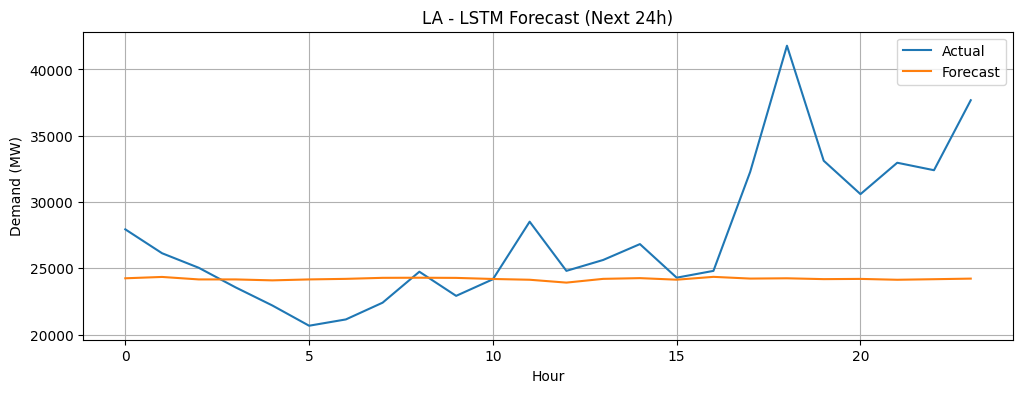

{'city': 'la', 'rmse': np.float64(6282.706497134447), 'mape': np.float64(14.437557208326801)}


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Parameters
SEQ_LEN = 24
FORECAST_LEN = 24
EPOCHS = 20
BATCH_SIZE = 32

city_to_subregion = {
    'san_diego': 'SDGE', 'la': 'SCE', 'san_jose': 'PGAE', 'phoenix': 'ZONA',
    'seattle': 'ZONH', 'dallas': 'CSWS', 'houston': 'CSWS',
    'san_antonio': 'CSWS', 'philadelphia': 'PECO', 'nyc': 'NYIS'
}

# old code

# def train_city_lstm(city, weather_df, energy_df):
#     subregion = city_to_subregion[city]

#     # filter relevant data
#     weather = weather_df[weather_df['city'] == city]
#     energy = energy_df[energy_df['Sub-Region'] == subregion]

#     join_keys = ['hour', 'day_of_week', 'month', 'season']
#     weather = weather.set_index(join_keys).sort_index()
#     energy = energy.set_index(join_keys).sort_index()

#     # align indices
#     aligned_idx = weather.index.intersection(energy.index)
#     weather = weather.loc[aligned_idx]
#     energy = energy.loc[aligned_idx]

#     # Features and target
#     X = weather[['precipIntensity', 'precipProbability', 'temperature',
#                  'apparentTemperature', 'humidity', 'pressure', 'windSpeed',
#                  'windGust', 'windBearing', 'cloudCover', 'uvIndex',
#                  'visibility', 'ozone']].values
#     y = energy['Demand (MW)'].values.reshape(-1, 1)

#     # Normalize
#     x_scaler = MinMaxScaler()
#     y_scaler = MinMaxScaler()
#     X_scaled = x_scaler.fit_transform(X)
#     y_scaled = y_scaler.fit_transform(y)

#     # Sequence generation
#     X_seq, y_seq = [], []
#     for i in range(len(X_scaled) - SEQ_LEN - FORECAST_LEN):
#         x_chunk = X_scaled[i:i + SEQ_LEN]
#         y_chunk = y_scaled[i + SEQ_LEN:i + SEQ_LEN + FORECAST_LEN]

#         if len(y_chunk) == FORECAST_LEN:  # Ensure target chunk is complete
#             X_seq.append(x_chunk)
#             y_seq.append(y_chunk.flatten())

#     X_seq, y_seq = np.array(X_seq), np.array(y_seq)




#     # split
#     split = int(len(X_seq) * 0.8)
#     X_train, y_train = X_seq[:split], y_seq[:split]
#     X_val, y_val = X_seq[split:], y_seq[split:]

#     # LSTM model
#     model = Sequential([
#         LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, X_seq.shape[2])),
#         Dropout(0.2),
#         LSTM(64),
#         Dropout(0.2),
#         Dense(FORECAST_LEN)
#     ])
#     model.compile(optimizer='adam', loss='mse')

#     # Early stopping
#     # es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#     history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
#                         validation_data=(X_val, y_val))

#     # Predict on validation
#     y_pred_scaled = model.predict(X_val)
#     y_pred = y_scaler.inverse_transform(y_pred_scaled)
#     y_true = y_scaler.inverse_transform(y_val)

#     plt.figure(figsize=(10, 4))
#     plt.plot(history.history['loss'], label='Train Loss')
#     plt.plot(history.history['val_loss'], label='Val Loss')
#     plt.title(f'{city.upper()} - Loss vs Epoch')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()

#     plt.figure(figsize=(12, 4))
#     plt.plot(y_true[0], label='Actual')
#     plt.plot(y_pred[0], label='Forecast')
#     plt.title(f'{city.upper()} - 24h Forecast vs Actual')
#     plt.xlabel('Hour')
#     plt.ylabel('Demand (MW)')
#     plt.legend()
#     plt.show()

#     return model, history

# model, hist = train_city_lstm('la', weather_clean, merged_df)


# new code

def train_city_lstm(city, weather_df, energy_df, selected_date):
    subregion = city_to_subregion[city]

    # Filter data
    weather = weather_df[weather_df['city'] == city].copy()
    energy = energy_df[energy_df['Sub-Region'] == subregion].copy()

    # Convert date
    selected_date = pd.to_datetime(selected_date)

    # Use only data before the selected forecast date
    energy = energy[energy['UTC Time at End of Hour_subregion'] < selected_date]
    if energy.empty or len(energy) < 100:
        raise ValueError("Not enough data before selected date for LSTM.")

    join_keys = ['hour', 'day_of_week', 'month', 'season']
    weather = weather.set_index(join_keys).sort_index()
    energy = energy.set_index(join_keys).sort_index()

    aligned_idx = weather.index.intersection(energy.index)
    weather = weather.loc[aligned_idx]
    energy = energy.loc[aligned_idx]

    weather.reset_index(inplace=True)

    # X = weather[['precipIntensity', 'precipProbability', 'temperature',
    #              'apparentTemperature', 'humidity', 'pressure', 'windSpeed', 'dewPoint',
    #              'windGust', 'windBearing', 'cloudCover', 'uvIndex',
    #              'visibility', 'ozone', 'hour', 'day_of_week', 'month']].values


    X = weather[['precipIntensity', 'dewPoint', 'temperature', 'windBearing', 'humidity', 'windSpeed']].values


    y = energy['Demand (MW)'].values.reshape(-1, 1)

    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    X_scaled = x_scaler.fit_transform(X)
    y_scaled = y_scaler.fit_transform(y)

    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - SEQ_LEN - FORECAST_LEN):
        x_chunk = X_scaled[i:i + SEQ_LEN]
        y_chunk = y_scaled[i + SEQ_LEN:i + SEQ_LEN + FORECAST_LEN]
        if len(y_chunk) == FORECAST_LEN:
            X_seq.append(x_chunk)
            y_seq.append(y_chunk.flatten())

    X_seq, y_seq = np.array(X_seq), np.array(y_seq)
    split = int(len(X_seq) * 0.8)
    X_train, y_train = X_seq[:split], y_seq[:split]
    X_val, y_val = X_seq[split:], y_seq[split:]

    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, X_seq.shape[2])),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(FORECAST_LEN)
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        validation_data=(X_val, y_val))

    y_pred_scaled = model.predict(X_val)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_true = y_scaler.inverse_transform(y_val)

    plt.figure(figsize=(12, 4))
    plt.plot(y_true[0], label='Actual')
    plt.plot(y_pred[0], label='Forecast')
    plt.title(f'{city.upper()} - LSTM Forecast (Next 24h)')
    plt.xlabel('Hour')
    plt.ylabel('Demand (MW)')
    plt.legend()
    plt.grid(True)
    image_path = f"/content/drive/MyDrive/DataMining_Project/static/{city}_lstm_forecast.png"
    plt.savefig(image_path)
    plt.show()
    plt.close()

    rmse = np.sqrt(np.mean((y_true.flatten() - y_pred.flatten())**2))
    mape = np.mean(np.abs((y_true.flatten() - y_pred.flatten()) / y_true.flatten())) * 100

    return {
        'city': city,
        'rmse': rmse,
        'mape': mape,
        'plot_path': f"{city}_lstm_forecast.png"
    }


city = 'la'  # Sample city
selected_date = '2020-04-01'  # Sample date for forecasting

# Call the function
result = train_city_lstm(city, weather_clean, merged_df, selected_date)

# Display the result
print(result)

LSTM - city

Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0433 - val_loss: 0.0181
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0113 - val_loss: 0.0236
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0098 - val_loss: 0.0234
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0084 - val_loss: 0.0239
Epoch 5/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0052 - val_loss: 0.0184
Epoch 6/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0047 - val_loss: 0.0168
Epoch 7/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0044 - val_loss: 0.0189
Epoch 8/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0041 - val_loss: 0.0182
Epoch 9/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0041 - val_loss: 0.0201
Epoch 10/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0039 - val_loss: 0.0154
Epoch 11/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0037 - val_loss: 0.0147
Epoch 12/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/st

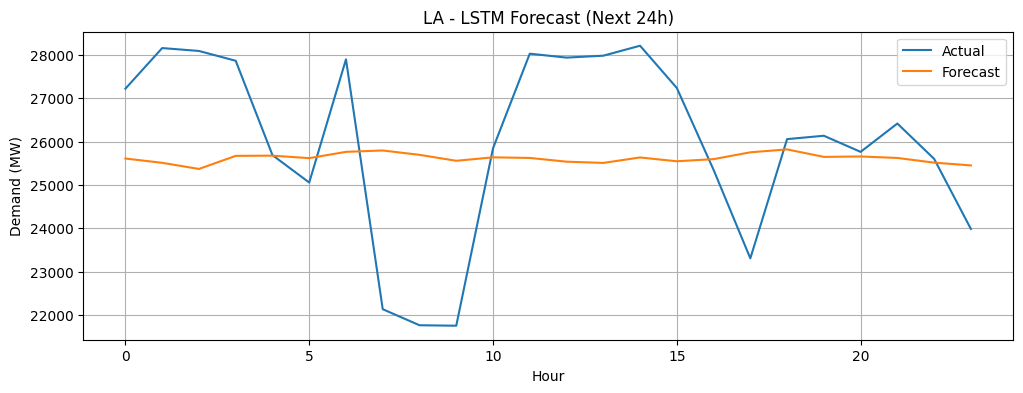

{'city': 'la', 'rmse': np.float64(5643.158547396367), 'mape': np.float64(14.387960661055436)}


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Parameters
SEQ_LEN = 24  # Sequence length for LSTM input
FORECAST_LEN = 24  # Forecast length
EPOCHS = 20  # Number of epochs
BATCH_SIZE = 32  # Batch size

city_to_subregion = {
    'san_diego': 'SDGE', 'la': 'SCE', 'san_jose': 'PGAE', 'phoenix': 'ZONA',
    'seattle': 'ZONH', 'dallas': 'CSWS', 'houston': 'CSWS',
    'san_antonio': 'CSWS', 'philadelphia': 'PECO', 'nyc': 'NYIS'
}

def train_city_lstm(city, weather_df, energy_df, selected_date):
    subregion = city_to_subregion[city]

    # Filter data for the city
    weather = weather_df[weather_df['city'] == city].copy()
    energy = energy_df[energy_df['Sub-Region'] == subregion].copy()

    # Convert selected date to datetime
    selected_date = pd.to_datetime(selected_date)

    # Use only data before the selected forecast date
    energy = energy[energy['UTC Time at End of Hour_subregion'] < selected_date]
    if energy.empty or len(energy) < 100:
        raise ValueError("Not enough data before selected date for LSTM.")

    # Keep only temporal features (remove weather data)
    weather = weather[['hour', 'month']]

    # Join weather and energy data on temporal features
    weather = weather.set_index(['hour', 'month']).sort_index()
    energy = energy.set_index(['hour', 'month']).sort_index()

    aligned_idx = weather.index.intersection(energy.index)
    weather = weather.loc[aligned_idx]
    energy = energy.loc[aligned_idx]

    weather.reset_index(inplace=True)

    # Features (X) and target (y)
    X = weather[['hour', 'month']].values
    y = energy['Demand (MW)'].values.reshape(-1, 1)

    # Scale the data
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    X_scaled = x_scaler.fit_transform(X)
    y_scaled = y_scaler.fit_transform(y)

    # Create sequences for LSTM
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - SEQ_LEN - FORECAST_LEN):
        x_chunk = X_scaled[i:i + SEQ_LEN]
        y_chunk = y_scaled[i + SEQ_LEN:i + SEQ_LEN + FORECAST_LEN]
        if len(y_chunk) == FORECAST_LEN:
            X_seq.append(x_chunk)
            y_seq.append(y_chunk.flatten())

    X_seq, y_seq = np.array(X_seq), np.array(y_seq)
    split = int(len(X_seq) * 0.8)
    X_train, y_train = X_seq[:split], y_seq[:split]
    X_val, y_val = X_seq[split:], y_seq[split:]

    # Build the LSTM model
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, X_seq.shape[2])),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(FORECAST_LEN)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        validation_data=(X_val, y_val))

    # Make predictions
    y_pred_scaled = model.predict(X_val)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_true = y_scaler.inverse_transform(y_val)

    # Plot the results
    plt.figure(figsize=(12, 4))
    plt.plot(y_true[0], label='Actual')
    plt.plot(y_pred[0], label='Forecast')
    plt.title(f'{city.upper()} - LSTM Forecast (Next 24h)')
    plt.xlabel('Hour')
    plt.ylabel('Demand (MW)')
    plt.legend()
    plt.grid(True)
    # image_path = f"/content/drive/MyDrive/DataMining_Project/static/{city}_lstm_forecast_no_weather.png"
    # plt.savefig(image_path)
    plt.show()
    plt.close()

    # Calculate RMSE and MAPE
    rmse = np.sqrt(np.mean((y_true.flatten() - y_pred.flatten())**2))
    mape = np.mean(np.abs((y_true.flatten() - y_pred.flatten()) / y_true.flatten())) * 100

    return {
        'city': city,
        'rmse': rmse,
        'mape': mape,
        # 'plot_path': f"{city}_lstm_forecast_no_weather.png"
    }

# Example city and selected date
city = 'la'  # Sample city
selected_date = '2020-04-01'  # Sample date for forecasting

# Call the function
result = train_city_lstm(city, weather_clean, merged_df, selected_date)

# Display the result
print(result)


Ensemble Learning - XgBoost

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/DataMining_Project/static/la_xgb_forecast.png'

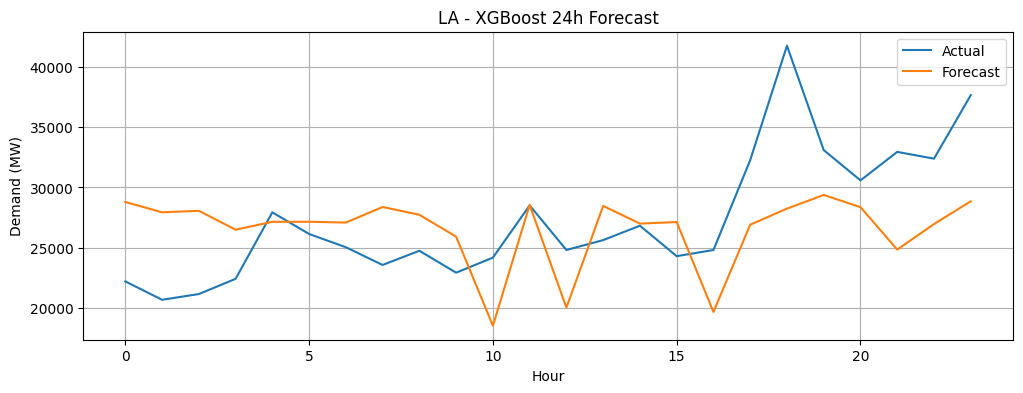

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

SEQ_LEN = 24
FORECAST_LEN = 24

city_to_subregion = {
    'san_diego': 'SDGE', 'la': 'SCE', 'san_jose': 'PGAE', 'phoenix': 'ZONA',
    'seattle': 'ZONH', 'dallas': 'CSWS', 'houston': 'CSWS',
    'san_antonio': 'CSWS', 'philadelphia': 'PECO', 'nyc': 'NYIS'
}

# old code

# def train_city_xgb(city, weather_df, energy_df):
#     subregion = city_to_subregion[city]

#     # Filter city and subregion
#     weather = weather_df[weather_df['city'] == city].copy()
#     energy = energy_df[energy_df['Sub-Region'] == subregion].copy()

#     # Align on time features (excluding 'season')
#     join_keys = ['hour', 'day_of_week', 'month']
#     weather = weather.set_index(join_keys).sort_index()
#     energy = energy.set_index(join_keys).sort_index()

#     aligned_idx = weather.index.intersection(energy.index)
#     weather = weather.loc[aligned_idx]
#     energy = energy.loc[aligned_idx]

#     # Reset index to reintroduce time features
#     weather.reset_index(inplace=True)

#     # Feature columns (no 'season')
#     X = weather[['precipIntensity', 'precipProbability', 'temperature',
#                  'apparentTemperature', 'humidity', 'pressure', 'windSpeed',
#                  'windGust', 'windBearing', 'cloudCover', 'uvIndex',
#                  'visibility', 'ozone', 'hour', 'day_of_week', 'month']].values

#     y = energy['Demand (MW)'].values

#     # Normalize
#     x_scaler = MinMaxScaler()
#     y_scaler = MinMaxScaler()
#     X_scaled = x_scaler.fit_transform(X)

#     y_log = np.log1p(y)
#     y_scaled = y_scaler.fit_transform(y_log.reshape(-1, 1)).flatten()

#     # Create rolling windows
#     X_seq, y_seq = [], []
#     for i in range(len(X_scaled) - SEQ_LEN - FORECAST_LEN):
#         x_window = X_scaled[i:i + SEQ_LEN].flatten()
#         y_window = y_scaled[i + SEQ_LEN:i + SEQ_LEN + FORECAST_LEN]
#         if len(y_window) == FORECAST_LEN:
#             X_seq.append(x_window)
#             y_seq.append(y_window)

#     X_seq, y_seq = np.array(X_seq), np.array(y_seq)

#     # Check for sufficient data
#     if len(X_seq) == 0:
#         print(f"Not enough aligned data for city: {city}")
#         return None, None

#     # Train-test split
#     split = int(0.8 * len(X_seq))
#     X_train, y_train = X_seq[:split], y_seq[:split]
#     X_test, y_test = X_seq[split:], y_seq[split:]

#     # XGBoost model
#     model = xgb.XGBRegressor(
#         n_estimators=250,
#         learning_rate=0.01,
#         max_depth=5,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         objective='reg:squarederror',
#         random_state=42,
#         verbosity=1,
#         n_jobs=-1
#     )

#     # Multi-output: one model per forecast hour
#     models = []
#     preds = []
#     for hour in range(FORECAST_LEN):
#         m = xgb.XGBRegressor(**model.get_params())
#         m.fit(X_train, y_train[:, hour])
#         models.append(m)
#         preds.append(m.predict(X_test))

#     y_pred_scaled = np.array(preds).T
#     y_pred = np.expm1(y_scaler.inverse_transform(y_pred_scaled))
#     y_true = np.expm1(y_scaler.inverse_transform(y_test))

#     # Plot forecast vs actual
#     plt.figure(figsize=(12, 4))
#     plt.plot(y_true[0], label='Actual')
#     plt.plot(y_pred[0], label='Forecast')
#     plt.title(f'{city.upper()} - XGBoost 24h Forecast')
#     plt.xlabel('Hour')
#     plt.ylabel('Demand (MW)')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     # Evaluation metrics
#     rmse = np.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
#     mape = mean_absolute_percentage_error(y_true.flatten(), y_pred.flatten()) * 100
#     print(f"RMSE for {city.upper()} (XGBoost): {rmse:.2f}")
#     print(f"MAPE: {mape:.2f}%")

#     return models, rmse

# # Usage
# models, error = train_city_xgb('la', weather_clean, merged_df)



def train_city_xgb(city, weather_df, energy_df, selected_date):
    subregion = city_to_subregion[city]
    selected_date = pd.to_datetime(selected_date)

    # Filter and align
    weather = weather_df[weather_df['city'] == city].copy()
    energy = energy_df[energy_df['Sub-Region'] == subregion].copy()

    energy = energy[energy['UTC Time at End of Hour_subregion'] < selected_date]

    join_keys = ['hour', 'day_of_week', 'month']
    weather = weather.set_index(join_keys).sort_index()
    energy = energy.set_index(join_keys).sort_index()

    aligned_idx = weather.index.intersection(energy.index)
    weather = weather.loc[aligned_idx]
    energy = energy.loc[aligned_idx]
    weather.reset_index(inplace=True)

    if len(weather) < SEQ_LEN + FORECAST_LEN:
        raise ValueError("Not enough aligned weather-energy data for XGBoost.")

    # Features & target
    X = weather[['precipIntensity', 'precipProbability', 'temperature',
                 'apparentTemperature', 'humidity', 'pressure', 'windSpeed',
                 'windGust', 'windBearing', 'cloudCover', 'uvIndex',
                 'visibility', 'ozone', 'hour', 'day_of_week', 'month']].values
    y = energy['Demand (MW)'].values

    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    X_scaled = x_scaler.fit_transform(X)
    y_scaled = y_scaler.fit_transform(np.log1p(y).reshape(-1, 1)).flatten()

    # Create rolling windows
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - SEQ_LEN - FORECAST_LEN):
        x_window = X_scaled[i:i + SEQ_LEN].flatten()
        y_window = y_scaled[i + SEQ_LEN:i + SEQ_LEN + FORECAST_LEN]
        if len(y_window) == FORECAST_LEN:
            X_seq.append(x_window)
            y_seq.append(y_window)

    X_seq, y_seq = np.array(X_seq), np.array(y_seq)
    if len(X_seq) == 0:
        raise ValueError("Insufficient sequence length.")

    split = int(0.8 * len(X_seq))
    X_train, y_train = X_seq[:split], y_seq[:split]
    X_test, y_test = X_seq[split:], y_seq[split:]

    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        verbosity=0,
        n_jobs=-1
    )

    models = []
    preds = []
    for hour in range(FORECAST_LEN):
        m = xgb.XGBRegressor(**model.get_params())
        m.fit(X_train, y_train[:, hour])
        models.append(m)
        preds.append(m.predict(X_test))

    y_pred_scaled = np.array(preds).T
    y_pred = np.expm1(y_scaler.inverse_transform(y_pred_scaled))
    y_true = np.expm1(y_scaler.inverse_transform(y_test))

    # Save forecast plot
    plt.figure(figsize=(12, 4))
    plt.plot(y_true[0], label='Actual')
    plt.plot(y_pred[0], label='Forecast')
    plt.title(f'{city.upper()} - XGBoost 24h Forecast')
    plt.xlabel('Hour')
    plt.ylabel('Demand (MW)')
    plt.legend()
    plt.grid(True)
    image_path = f"/content/drive/MyDrive/DataMining_Project/static/{city}_xgb_forecast.png"
    plt.savefig(image_path)
    plt.close()

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    mape = mean_absolute_percentage_error(y_true.flatten(), y_pred.flatten()) * 100

    return {
        'city': city,
        'rmse': rmse,
        'mape': mape,
        'plot_path': f"{city}_xgb_forecast.png"
    }

# call
city = 'la'  # Sample city
selected_date = '2020-04-01'  # Sample date for forecasting

# Call the function
result = train_city_xgb(city, weather_clean, merged_df, selected_date)

# Display the result
print(result)

Ensemble Learning - xgBoost(HP)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import xgboost as xgb

def train_city_xgb(city, weather_df, energy_df, selected_date):
    subregion = city_to_subregion[city]
    selected_date = pd.to_datetime(selected_date)

    # Filter and align data
    weather = weather_df[weather_df['city'] == city].copy()
    energy = energy_df[energy_df['Sub-Region'] == subregion].copy()

    energy = energy[energy['UTC Time at End of Hour_subregion'] < selected_date]

    join_keys = ['hour', 'day_of_week', 'month']
    weather = weather.set_index(join_keys).sort_index()
    energy = energy.set_index(join_keys).sort_index()

    aligned_idx = weather.index.intersection(energy.index)
    weather = weather.loc[aligned_idx]
    energy = energy.loc[aligned_idx]
    weather.reset_index(inplace=True)

    if len(weather) < SEQ_LEN + FORECAST_LEN:
        raise ValueError("Not enough aligned weather-energy data for XGBoost.")

    # Features & target
    X = weather[['precipIntensity', 'precipProbability', 'temperature',
                 'apparentTemperature', 'humidity', 'pressure', 'windSpeed',
                 'windGust', 'windBearing', 'cloudCover', 'uvIndex',
                 'visibility', 'ozone', 'hour', 'day_of_week', 'month']].values
    y = energy['Demand (MW)'].values

    # Normalize
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    X_scaled = x_scaler.fit_transform(X)
    y_scaled = y_scaler.fit_transform(np.log1p(y).reshape(-1, 1)).flatten()

    # Create rolling windows
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - SEQ_LEN - FORECAST_LEN):
        x_window = X_scaled[i:i + SEQ_LEN].flatten()
        y_window = y_scaled[i + SEQ_LEN:i + SEQ_LEN + FORECAST_LEN]
        if len(y_window) == FORECAST_LEN:
            X_seq.append(x_window)
            y_seq.append(y_window)

    X_seq, y_seq = np.array(X_seq), np.array(y_seq)
    if len(X_seq) == 0:
        raise ValueError("Insufficient sequence length.")

    split = int(0.8 * len(X_seq))
    X_train, y_train = X_seq[:split], y_seq[:split]
    X_test, y_test = X_seq[split:], y_seq[split:]

    # Define the model
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0, n_jobs=-1)

    # Define the parameter grid for RandomizedSearchCV
    param_dist = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7, 9],
        'subsample': [0.6, 0.7, 0.8, 0.9],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [0, 0.1, 1]
    }

    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(
        model, param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error',
        cv=3, verbose=1, random_state=42, n_jobs=-1
    )

    random_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = random_search.best_params_

    print(f"Best hyperparameters found: {best_params}")

    # Train the model with the best parameters
    best_model = random_search.best_estimator_

    # Predict with the best model
    y_pred_scaled = np.array([best_model.predict(X_test) for hour in range(FORECAST_LEN)]).T
    y_pred = np.expm1(y_scaler.inverse_transform(y_pred_scaled))
    y_true = np.expm1(y_scaler.inverse_transform(y_test))

    # Save forecast plot
    plt.figure(figsize=(12, 4))
    plt.plot(y_true[0], label='Actual')
    plt.plot(y_pred[0], label='Forecast')
    plt.title(f'{city.upper()} - XGBoost 24h Forecast')
    plt.xlabel('Hour')
    plt.ylabel('Demand (MW)')
    plt.legend()
    plt.grid(True)
    # image_path = f"/content/drive/MyDrive/DataMining_Project/static/{city}_xgb_tuned_forecast.png"
    # plt.savefig(image_path)
    plt.close()

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    mape = mean_absolute_percentage_error(y_true.flatten(), y_pred.flatten()) * 100

    return {
        'city': city,
        'rmse': rmse,
        'mape': mape,
        # 'plot_path': f"{city}_xgb_tuned_forecast.png"
    }

# Call the function with hyperparameter tuning
city = 'la'  # Example city
selected_date = '2020-04-01'  # Example selected date

# Call the function
result = train_city_xgb(city, weather_clean, merged_df, selected_date)

# Display the result
print(result)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
la_demand = merged_df[merged_df['Sub-Region'] == 'SCE']['Demand (MW)']
print("LA Demand Range (MW):", la_demand.min(), "-", la_demand.max())


LA Demand Range (MW): 14.0 - 46133.0


In [ ]:
print("Demand range (MW):", merged_df['Demand (MW)'].min(), "-", merged_df['Demand (MW)'].max())


Demand range (MW): 0.0 - 417669.0


# Findings

Correlation to back my statement.<br>
Different models yield different results.

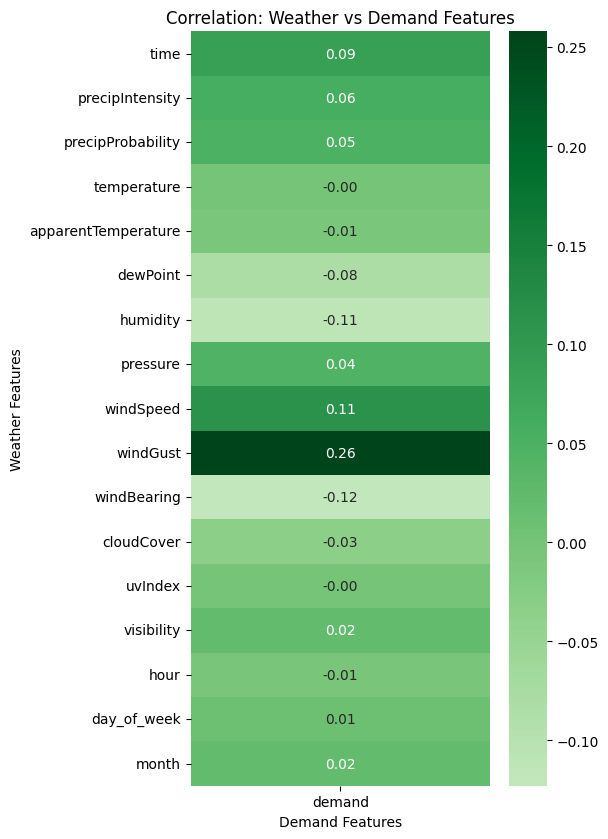

In [ ]:

# Select numeric columns
numeric_weather_clean = weather_clean.select_dtypes(include=['number', 'float', 'int'])
numeric_merged_df = demand_df.select_dtypes(include=['number', 'float', 'int'])

# Combine into one DataFrame
combined_df = pd.concat([numeric_weather_clean, numeric_merged_df], axis=1)

# Get column boundaries
weather_cols = numeric_weather_clean.columns
demand_cols = numeric_merged_df.columns

# Compute correlation
correlation_matrix = combined_df.corr()


# Compute cross-correlation only
correlation_values = pd.DataFrame(index=numeric_weather_clean.columns, columns=numeric_merged_df.columns)

for w_col in numeric_weather_clean.columns:
    for d_col in numeric_merged_df.columns:
        corr = numeric_weather_clean[w_col].corr(numeric_merged_df[d_col])
        correlation_values.loc[w_col, d_col] = corr

# Convert to float
correlation_values = correlation_values.astype(float)

# Plot
plt.figure(figsize=(6, len(correlation_values) * 0.5))
sns.heatmap(correlation_values, annot=True, cmap="Greens", center=0, fmt=".2f")
plt.title("Correlation: Weather vs Demand Features")
plt.xlabel("Demand Features")
plt.ylabel("Weather Features")
plt.tight_layout()
plt.show()


 **conclusion:** Most correlations are weak (close to 0), meaning weather features have little influence on electricty demand.

# Frontend - UI

In [ ]:
pip install flask

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount= True)
templates_path = '/content/drive/My Drive/DataMining_Project/templates'
static_path= '/content/drive/My Drive/DataMining_Project/static'
os.makedirs(templates_path, exist_ok= True)
os.makedirs(static_path, exist_ok=True)

Mounted at /content/drive


In [ ]:
!pip install flask pyngrok

In [ ]:
from flask import Flask, render_template, request
from pyngrok import ngrok, conf

# Set your ngrok authtoken
conf.get_default().auth_token = "2wjRaqkvrE9VpJU3JjmjpRn9SVi_6ADtPgVDpGhKG2mPq3qrX"

# Create the Flask app
app = Flask(__name__)

# Set the template and static folder paths
app.template_folder = '/content/drive/MyDrive/DataMining_Project/templates'
app.static_folder = '/content/drive/MyDrive/DataMining_Project/static'

# Start an ngrok tunnel to the Flask app
public_url = ngrok.connect(5000)
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:5000\"")

# Setting up routes for each HTML page
@app.route('/')
def home():
    return render_template('home.html')

@app.route('/city_date')
def city_date():
    return render_template('city_date.html')

@app.route('/model_sel')
def model_selection():
    return render_template('model_selection.html')

# arima
@app.route('/forecast_arima')
def forecast_result():
    city = request.args.get('city')
    date = request.args.get('date')
    p = int(request.args.get('p', 2))
    d = int(request.args.get('d', 1))
    q = int(request.args.get('q', 2))

    try:
        result = arima_forecast(merged_df, city, date, p, d, q)
        return render_template('arima.html',
                               city=city,
                               mae=result['mae'],
                               rmse=result['rmse'],
                               mape=result['mape'],
                               image=result['plot_path'])
    except Exception as e:
        return f"Error generating forecast: {str(e)}"

# lstm
@app.route('/forecast_lstm')
def forecast_lstm():
    city = request.args.get('city')
    date = request.args.get('date')

    try:
        result = train_city_lstm(city, weather_clean, merged_df, selected_date=date)
        return render_template('lstm.html',
                               city=city,
                               rmse=result['rmse'],
                               mape=result['mape'],
                               mae='–',
                               image=result['plot_path'])
    except Exception as e:
        return f"Error running LSTM for {city} on {date}: {str(e)}"

# xgboost
@app.route('/forecast_xgb')
def forecast_xgb():
    city = request.args.get('city')
    date = request.args.get('date')

    try:
        result = train_city_xgb(city, weather_clean, merged_df, selected_date=date)
        return render_template('xgboost.html',
                               city=city,
                               rmse=result['rmse'],
                               mape=result['mape'],
                               image=result['plot_path'])
    except Exception as e:
        return f"Error running XGBoost for {city} on {date}: {str(e)}"


@app.route('/kmeans_clusters')
def kmeans_clusters():
    try:
        k_param = request.args.get('k', '2')
        k = int(k_param) if k_param.isdigit() else 2
        image_path = generate_kmeans_plot(weather_clean, demand_df, k)
        return render_template('k.html', image=image_path, k=k)
    except Exception as e:
        return f"Error generating KMeans clusters: {str(e)}"





@app.route('/dbscan_clusters')
def dbscan_clusters():
    try:
        image_path = dbscan_monthly_clustering_v3(subregion_df)
        return render_template('dbscan.html', image=image_path)
    except Exception as e:
        return f"Error running DBSCAN clustering: {str(e)}"




if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)


 * ngrok tunnel "NgrokTunnel: "https://5c8e-34-169-173-84.ngrok-free.app" -> "http://localhost:5000"" -> "http://127.0.0.1:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [10/May/2025 13:34:38] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/May/2025 13:34:39] "GET /static/img1.jpeg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/May/2025 13:34:39] "GET /static/style.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/May/2025 13:34:41] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [10/May/2025 13:34:43] "GET /city_date HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/May/2025 13:34:44] "GET /static/style.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [10/May/2025 13:34:51] "GET /model_sel HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/May/2025 13:34:52] "GET /static/style.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [10/May